# Working directory.


In [17]:
import os
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import joblib

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
os.chdir("/content/drive/MyDrive/project portfolio /code (script and workbooks)/Value.AI/Data")
df = pd.read_csv("/content/drive/MyDrive/project portfolio /code (script and workbooks)/Value.AI/Data/player_stats.csv", encoding='latin1')

In [7]:

def Cleaner(file_path):
    # reading the csv
    df = pd.read_csv(file_path, encoding="latin1")

    # dropping duplicates
    df = df.drop_duplicates()

    # Clean the column
    df["value"] = (
    df["value"]
    .str.replace("$", "", regex=False)   # remove dollar sign
    .str.replace(".", "", regex=False)   # remove dots (thousand separators)
    .astype(int)                         # convert to integer
                )

    # Split player name by space and take the first word as surname
    df["surname"] = df["player"].str.split(" ").str[0]
    # Keep the first occurrence of each surname, drop duplicates
   # Drop duplicates by both surname + value (so top players like Mbappé are kept)
    df = df.drop_duplicates(subset=["surname", "value"], keep="last")

    #drop the surname
    df = df.drop(columns=["surname"], errors="ignore")

    # categories
    tackle = ['slide_tackle', 'stand_tackle', 'aggression', 'interceptions', 'reactions']
    passing = ['long_pass', 'short_pass', 'vision', 'crossing']
    shooting = ['shot_power', 'long_shots']
    finishing = ['finishing', 'curve', 'penalties', 'volleys', 'composure']
    agility = ['agility', 'jumping', 'heading', 'balance']
    goalkeeping = ['gk_positioning', 'gk_diving', 'gk_handling', 'gk_reflexes','gk_kicking']
    pace_cols = ["acceleration", "sprint_speed"]
    dribbling_cols = ["dribbling", "agility"]
    attacking_cols = ["dribbling", "finishing", "shooting", "att_position"]
    strength_cols = ["stamina", "strength"]
    # Add skill columns
    df["defending"] = df[tackle].mean(axis=1)
    df["passing"] = df[passing].mean(axis=1)
    df["shooting"] = df[shooting].mean(axis=1)
    df["finishing"] = df[finishing].mean(axis=1)
    df["agility"] = df[agility].mean(axis=1)
    df["goalkeeping"] = df[goalkeeping].mean(axis=1)
    df["pace"] = df[pace_cols].mean(axis=1)
    df["dribbling"] = df[dribbling_cols].mean(axis=1)
    df["attacking"] = df[attacking_cols].mean(axis=1)
    df["strength"] = df[strength_cols].mean(axis=1)

    # Drop raw columns
    all_categories =  strength_cols+tackle + passing + shooting + finishing + agility + goalkeeping + pace_cols + dribbling_cols + attacking_cols + ["weight"]+["marking"]
    df = df.drop(columns=all_categories, errors="ignore")

    df = df.fillna(df.median(numeric_only=True))

    return df


In [8]:
cleaned_data = Cleaner("player_stats.csv")
#print(cleaned_data.head())

# column to list
print(cleaned_data.columns.tolist())
print(len(cleaned_data.columns))

cleaned_data.info()

dataset=cleaned_data

['player', 'country', 'height', 'age', 'club', 'ball_control', 'fk_acc', 'value', 'defending', 'passing', 'goalkeeping', 'pace', 'attacking']
13
<class 'pandas.core.frame.DataFrame'>
Index: 5440 entries, 0 to 5681
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player        5440 non-null   object 
 1   country       5440 non-null   object 
 2   height        5440 non-null   int64  
 3   age           5440 non-null   int64  
 4   club          5440 non-null   object 
 5   ball_control  5440 non-null   int64  
 6   fk_acc        5440 non-null   int64  
 7   value         5440 non-null   int64  
 8   defending     5440 non-null   float64
 9   passing       5440 non-null   float64
 10  goalkeeping   5440 non-null   float64
 11  pace          5440 non-null   float64
 12  attacking     5440 non-null   float64
dtypes: float64(5), int64(5), object(3)
memory usage: 595.0+ KB


In [9]:
dataset

,player,country,height,age,club,ball_control,fk_acc,value,defending,passing,goalkeeping,pace,attacking
0,Cristian Castro Devenish,Colombia,192,22,Atl. Nacional,55,34,1400000,69.2,44.00,8.6,46.5,38.98750
1,Silaldo Taffarel,Brazil,181,31,Corinthians,69,62,97500,63.2,62.50,12.6,65.5,62.91250
2,Thomas DÃ¤hne,Germany,193,29,Holstein Kiel,25,15,1100000,28.2,29.00,69.0,47.0,25.63750
3,Michael Sollbauer,Austria,187,33,SK Rapid Wien,46,13,65000,67.2,46.00,10.2,49.0,42.25000
4,Diego Segovia,Uruguay,191,23,Independiente,14,10,30000,24.0,23.00,62.0,34.5,16.71250
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5677,Mohamed Salah,Egypt,175,31,Liverpool,86,69,99500000,58.8,81.25,12.4,89.0,85.87500
5678,Sadio Mané,Senegal,174,31,FC Bayern München,86,64,101000000,56.2,79.25,11.2,88.5,84.42500
5679,Neymar Jr,Brazil,175,31,Paris SG,94,87,99500000,49.8,84.75,11.8,87.0,84.80000
5680,Cristiano Ronaldo,Portugal,187,38,Al Nassr,87,75,31000000,47.4,75.50,11.6,79.0,88.20000


In [10]:
top5_player = cleaned_data[["player", "value"]].sort_values(by="value", ascending=False).head(5)
print(top5_player)

top5_countries = (
    cleaned_data.groupby("country")["value"]
    .sum()  # total sum of all player values per country
    .sort_values(ascending=False)
    .head(5)
)
print(top5_countries)



               player      value
5675    Kylian Mbappé  153500000
1965   Erling Haaland  123000000
4849  Kevin De Bruyne  107500000
5678       Sadio Mané  101000000
5679        Neymar Jr   99500000
country
Spain        1416114500
Brazil       1143609500
France       1095755500
England       879859100
Argentina     798469500
Name: value, dtype: int64


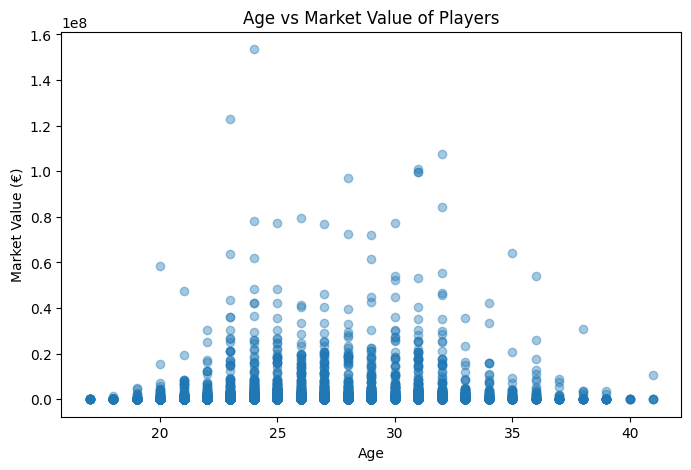

Correlation between Age and Value: 0.085


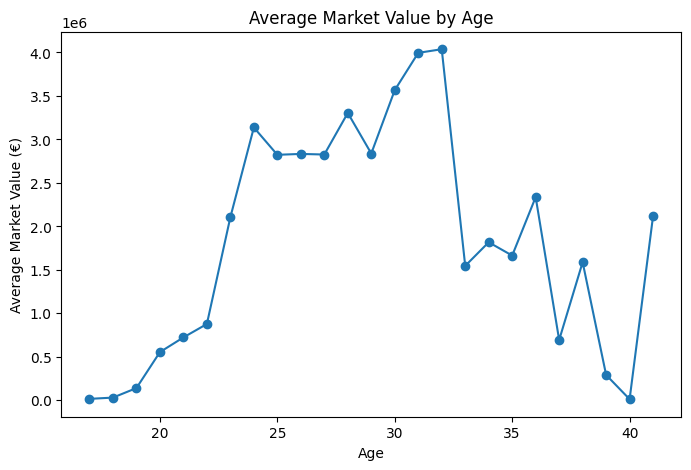

In [15]:

# Scatterplot of Age vs Value
plt.figure(figsize=(8,5))
plt.scatter(cleaned_data["age"], cleaned_data["value"], alpha=0.4)
plt.xlabel("Age")
plt.ylabel("Market Value (€)")
plt.title("Age vs Market Value of Players")
plt.show()

# Correlation between Age and Value
corr = cleaned_data["age"].corr(cleaned_data["value"])
print(f"Correlation between Age and Value: {corr:.3f}")

# Average value by age (to smooth it out)
avg_value_by_age = cleaned_data.groupby("age")["value"].mean()

plt.figure(figsize=(8,5))
avg_value_by_age.plot(kind="line", marker="o")
plt.xlabel("Age")
plt.ylabel("Average Market Value (€)")
plt.title("Average Market Value by Age")
plt.show()


# TRAINING THE MODEL

In [12]:
# Target variable
y = cleaned_data["value"]

# Feature matrix (all numeric predictors, excluding player info and target)
X = cleaned_data.drop(columns=["player", "club", "country", "value"])


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Random Forest Model

In [18]:

# Initialize Random Forest
rf_model = RandomForestRegressor(
    n_estimators=200,   # number of trees
    max_depth=None,     # let trees grow fully
    random_state=42,
    n_jobs=-1           # use all cores
)

# Fit
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest:")
print("MAE:", mae_rf)
print("RMSE:", rmse_rf)
print("R²:", r2_rf)


Random Forest:
MAE: 846380.4375
RMSE: 3740847.9437821195
R²: 0.8018458461319967


## GRADIANT BOOSTING

In [19]:

param_grid = {
    'n_estimators': [300, 500],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3]
}

# Initialize Gradient Boosting Regressor
gb = GradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    cv=3,               # 3-fold cross-validation
    scoring='r2',       # maximize R²
    n_jobs=-1,          # use all cores
    verbose=2
)

# Fit GridSearch to training data
grid_search.fit(X_train, y_train)

# Save the best tuned model
Value_model_beta = grid_search.best_estimator_

# Display best parameters and cross-validation R²
print("Best parameters:", grid_search.best_params_)
print("Best CV R²:", grid_search.best_score_)

y_pred_best = Value_model_beta.predict(X_test)

# Evaluate performance on test set
mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print("\nTuned Gradient Boosting Test Metrics:")
print("MAE:", mae_best)
print("RMSE:", rmse_best)
print("R²:", r2_best)


Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500, 'subsample': 0.8}
Best CV R²: 0.859953680974515

Tuned Gradient Boosting Test Metrics:
MAE: 743445.1243688072
RMSE: 2801253.7318597096
R²: 0.8888862088143938


In [20]:
# Fit GridSearch to training data
grid_search.fit(X, y)

# Save the best tuned model
Value_model_Alpha = grid_search.best_estimator_

# Save the model to the working directory
joblib.dump(Value_model_Alpha, "Value_model_Alpha.pkl")

Fitting 3 folds for each of 64 candidates, totalling 192 fits


['Value_model_Alpha.pkl']